In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from itertools import chain
import matplotlib.pyplot as plt

#from sklearn.model_selection import KFold
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

#from sklearn.decomposition import TruncatedSVD
#from gensim.models import Word2Vec
import ast
from ast import literal_eval
import re
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

from lightgbm import LGBMRegressor
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/bitfest-datathon-2025/train.csv')
test = pd.read_csv('/kaggle/input/bitfest-datathon-2025/test.csv')
print(train.shape)
print(test.shape)  # same column Number hoar kotha na !

(7635, 35)
(1909, 35)


In [3]:
print(set(train.columns) - set(test.columns))
print(set(test.columns) - set(train.columns))   ## See "ID" coln ta extra ..need to remove that !

{'matched_score'}
{'ID'}


In [4]:
test.drop(['ID'], axis=1, inplace=True)

In [5]:
train.head(2)

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.85
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.75


In [6]:
train_copy = train.copy()
test_copy = test.copy()

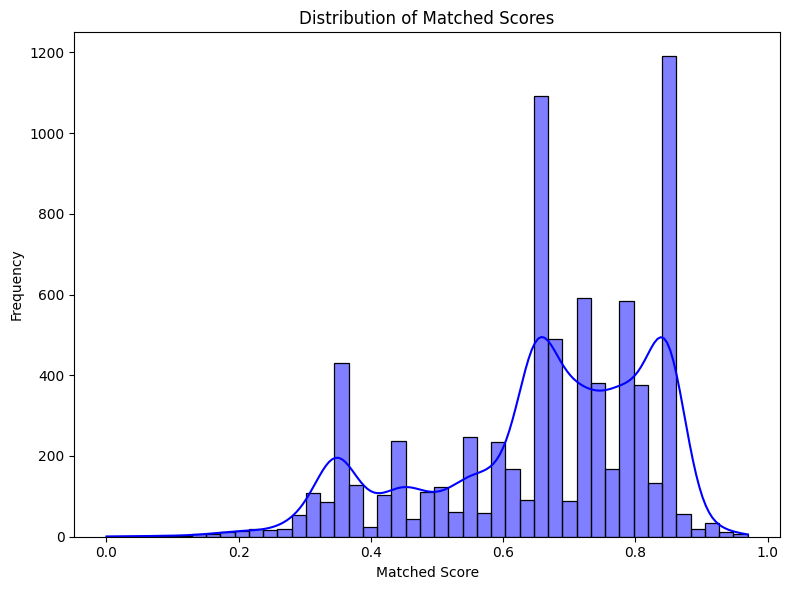

In [7]:
# Plot distribution of matched_score
plt.figure(figsize=(8, 6))
sns.histplot(train_copy['matched_score'], kde=True, color='blue')
plt.title('Distribution of Matched Scores')
plt.xlabel('Matched Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Prediction coln: Datatype to Float

In [8]:
print(train_copy['matched_score'].dtype)
# Convert matched_score column to float
train_copy['matched_score'] = pd.to_numeric(train_copy['matched_score'], errors='coerce')
print(train_copy['matched_score'].dtype)
# Verify the data type

float64
float64


# Work with train_copy and test_copy Side by Side

# Cleaning Column Names

In [9]:
import re

def check_special_chars(df):
    special_char_pattern = re.compile(r'[^a-zA-Z0-9_]')
    print("Columns with potential special characters:")
    for col in df.columns:
        if special_char_pattern.search(col):
            print(f"Column: {col}")

# Usage
print("Train dataset:")
check_special_chars(train_copy)

print("\nTest dataset:")
check_special_chars(test_copy)


Train dataset:
Columns with potential special characters:
Column: ﻿job_position_name
Column: responsibilities.1

Test dataset:
Columns with potential special characters:
Column: ﻿job_position_name
Column: responsibilities.1


In [10]:
def clean_column_names(df):
    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)  # Replace non-alphanumeric characters with '_'
    df.columns = df.columns.str.replace(r'\s+', '_', regex=True)  # Replace spaces with '_'
    return df

# Apply to both train and test datasets
train_copy = clean_column_names(train_copy)
test_copy = clean_column_names(test_copy)

print("Cleaned column names in train_copy:")
print(train_copy.columns)

print("\nCleaned column names in test_copy:")
print(test_copy.columns)


Cleaned column names in train_copy:
Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names', 'company_urls',
       'start_dates', 'end_dates', 'related_skils_in_job', 'positions',
       'locations', 'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names',
       'extra_curricular_organization_links', 'role_positions', 'languages',
       'proficiency_levels', 'certification_providers', 'certification_skills',
       'online_links', 'issue_dates', 'expiry_dates', '_job_position_name',
       'educationaL_requirements', 'experiencere_requirement',
       'age_requirement', 'responsibilities_1', 'skills_required',
       'matched_score'],
      dtype='object')

Cleaned column names in test_copy:
Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       

In [11]:
print("Data types in train_copy:")
print(train_copy.dtypes)

# print("\nData types in test_copy:")
# print(test_copy.dtypes)


## Cant work with Object Datatype ! Need to convert into Integers or float

Data types in train_copy:
address                                 object
career_objective                        object
skills                                  object
educational_institution_name            object
degree_names                            object
passing_years                           object
educational_results                     object
result_types                            object
major_field_of_studies                  object
professional_company_names              object
company_urls                            object
start_dates                             object
end_dates                               object
related_skils_in_job                    object
positions                               object
locations                               object
responsibilities                        object
extra_curricular_activity_types         object
extra_curricular_organization_names     object
extra_curricular_organization_links     object
role_positions                    

In [12]:
train_copy.columns

Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names', 'company_urls',
       'start_dates', 'end_dates', 'related_skils_in_job', 'positions',
       'locations', 'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names',
       'extra_curricular_organization_links', 'role_positions', 'languages',
       'proficiency_levels', 'certification_providers', 'certification_skills',
       'online_links', 'issue_dates', 'expiry_dates', '_job_position_name',
       'educationaL_requirements', 'experiencere_requirement',
       'age_requirement', 'responsibilities_1', 'skills_required',
       'matched_score'],
      dtype='object')

# Dropping Columns based on null values

In [13]:
def check_null_percentage(df):
    null_counts = df.isnull().sum()
    total_rows = len(df)
    null_percentage = (null_counts / total_rows) * 100
    unique_values = df.nunique()

    null_df = pd.DataFrame({
        'Missing Values': null_counts,
        'Missing Percentage': null_percentage,
        #'Unique Values': unique_values
    }).sort_values(by='Missing Percentage', ascending=False)

    return null_df

missing_train = check_null_percentage(train_copy)
print("#################")
print("Missing values in train dataset:")
print(missing_train)

# missing_test = check_null_percentage(test_copy)
# print("#################")
# print("Missing values in test dataset:")
# print(missing_test)


#################
Missing values in train dataset:
                                     Missing Values  Missing Percentage
proficiency_levels                             7066           92.547479
languages                                      7066           92.547479
address                                        7002           91.709234
expiry_dates                                   6048           79.214145
issue_dates                                    6048           79.214145
online_links                                   6048           79.214145
certification_skills                           6048           79.214145
certification_providers                        6048           79.214145
extra_curricular_organization_names            4903           64.217420
role_positions                                 4903           64.217420
extra_curricular_organization_links            4903           64.217420
extra_curricular_activity_types                4903           64.217420
career_object

In [14]:
print(len(train_copy.columns))

columns_to_remove = [
    'proficiency_levels', 
    'languages', 
    'address', 
    'expiry_dates', 
    'issue_dates', 
    'online_links', 
    'certification_skills', 
    'certification_providers',
    'extra_curricular_organization_links',
    'company_urls',
    'result_types'
]

train_copy.drop(columns=columns_to_remove, errors='ignore',inplace=True)
test_copy.drop(columns=columns_to_remove, errors='ignore', inplace=True)

print("Columns removed successfully.")
print(len(train_copy.columns))

35
Columns removed successfully.
24


# Replacing Nan with "missing"

In [15]:
import pandas as pd
import ast

def replace_missing_values_all_columns(df, excluded_columns=None):
    missing_values_list = [None, 'N/A', 'nan', 'NaN', 'n/a', 'N/a', 'na', 'NA', '', ' ']

    def clean_entry(entry):
        if isinstance(entry, str) and entry.startswith('[') and entry.endswith(']'):
            try:
                entry = ast.literal_eval(entry)
            except (ValueError, SyntaxError):
                entry = []

        if isinstance(entry, (list, pd.Series)):
            entry_items = list(entry)
        else:
            entry_items = [entry]
        
        is_valid = any(item not in missing_values_list and not pd.isna(item) for item in entry_items)
        
        return entry if is_valid else 'missing'
    
    excluded_columns = excluded_columns or []
    for column in df.columns:
        if column not in excluded_columns:
            df[column] = df[column].apply(lambda x: str(clean_entry(x)))
    
    return df

# Example Usage
excluded_columns = ['related_skils_in_job']

train_copy = replace_missing_values_all_columns(train_copy, excluded_columns)
test_copy = replace_missing_values_all_columns(test_copy, excluded_columns)

print("Missing values handled for all columns of train and test_copy except excluded ones.")


Missing values handled for all columns of train and test_copy except excluded ones.


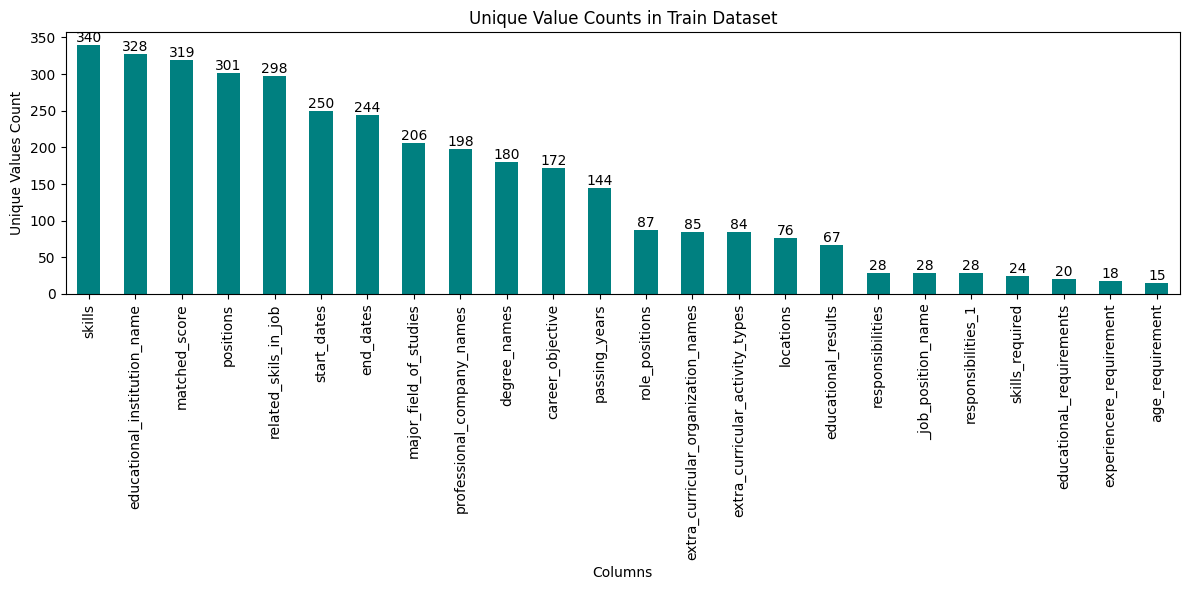

In [16]:
def plot_unique_value_counts(df, title="Unique Value Counts"):
    unique_counts = df.nunique().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    ax = unique_counts.plot(kind='bar', color='teal')
    
    # Add counts on top of each bar
    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())), 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='bottom', 
            fontsize=10
        )
    
    plt.title(title)
    plt.xlabel('Columns')
    plt.ylabel('Unique Values Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage
plot_unique_value_counts(train_copy, title="Unique Value Counts in Train Dataset")


In [17]:
def print_unique_entries(df, columns):
    for column in columns:
        if column in df.columns:
            unique_values = df[column].unique()
            print(f"Unique entries in '{column}':")
            print(unique_values.tolist())
            print("\n")
        else:
            print(f"Column '{column}' not found in the DataFrame.\n")

# Example usage
columns_to_check = ['educationaL_requirements']
print_unique_entries(train_copy, columns_to_check)


Unique entries in 'educationaL_requirements':
['B.Sc in Computer Science & Engineering from a reputed university.', 'M.Sc in Computer Science & Engineering or in any relevant discipline from a reputed University', 'Master of Business Administration (MBA)', 'Bachelor/Honors', 'Bachelor of Science (BSc) in Computer Science', 'Bachelors or Masters degree in Computer Science, Engineering, or a related field.', 'Bachelor of Science (BSc) in Mechanical Engineering, Diploma in Mechanical', 'Bachelor’s degree in Mechanical Engineering from a reputed institute.', '•Bachelor of Business Administration (BBA) in Human Resource Management', 'Bachelor of Science (BSc) in Computer Science & Engineering', 'Diploma, Bachelor/Honors', 'Bachelor of Science (BSc)', 'BBA in Accounting and Finance', 'Master of Commerce (MCom) in Accounting, Must have CACC certification from any CA firm', 'Fresh graduates with a Bachelor’s degree in Mechanical Engineering or a related field.', '•Bachelor of Business Administ

# Input coln vs Target coln

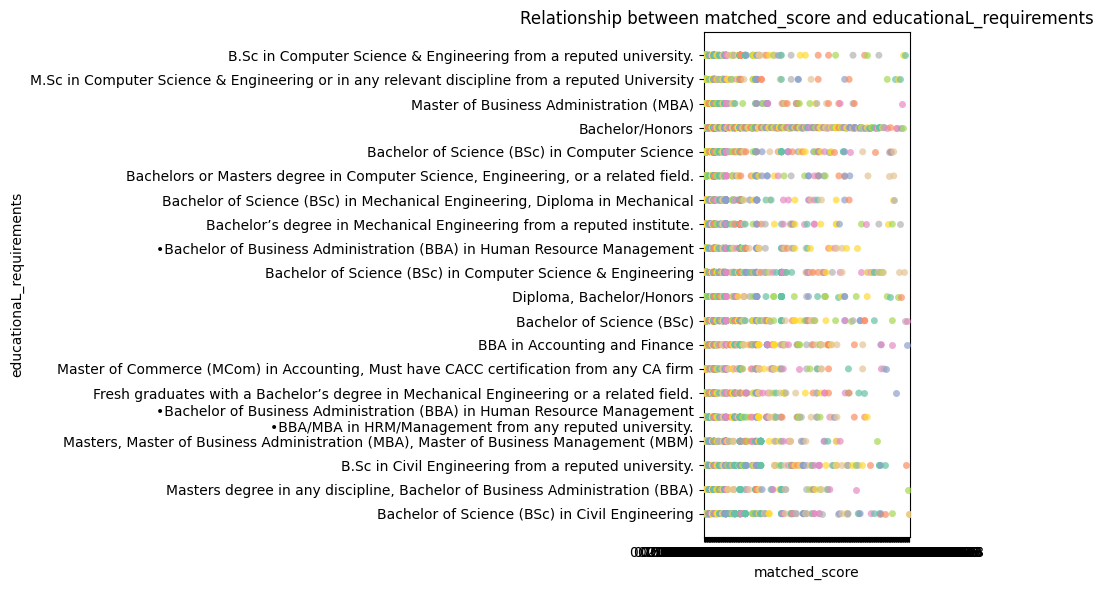

In [18]:
def plot_columns_vs_matched_score(df, columns, target="matched_score"):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.stripplot(data=df, y=column, x=target, palette="Set2", alpha=0.7, jitter=True)
        plt.title(f'Relationship between {target} and {column}')
        plt.xlabel(target)
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

# Example usage:
relation_cols = [
    'educationaL_requirements'
]

plot_columns_vs_matched_score(train_copy, relation_cols)


In [19]:
train_copy.columns

Index(['career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results',
       'major_field_of_studies', 'professional_company_names', 'start_dates',
       'end_dates', 'related_skils_in_job', 'positions', 'locations',
       'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names', 'role_positions',
       '_job_position_name', 'educationaL_requirements',
       'experiencere_requirement', 'age_requirement', 'responsibilities_1',
       'skills_required', 'matched_score'],
      dtype='object')

# Date and Numeric cols Extraction

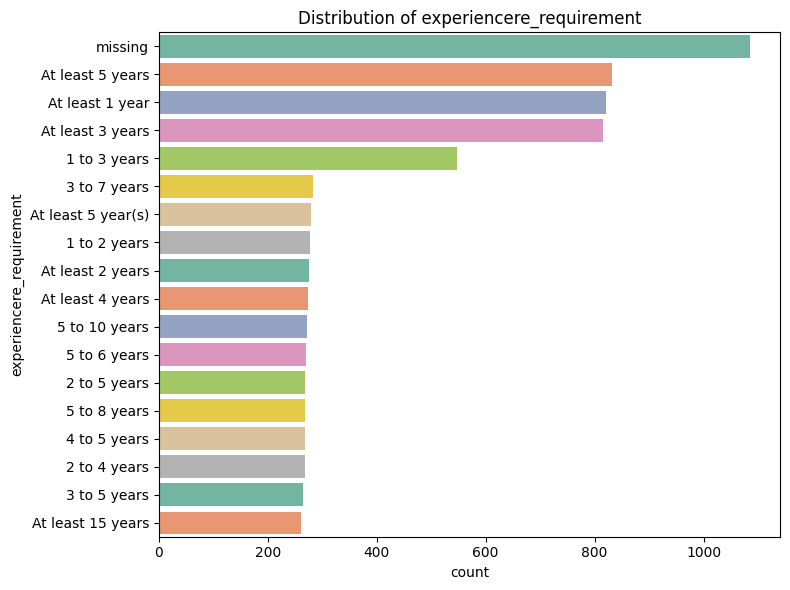

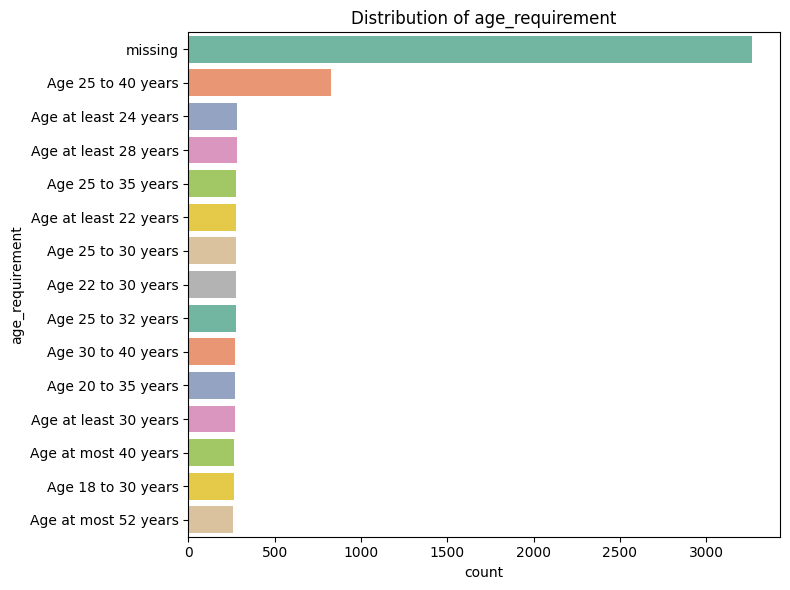

In [20]:
# Distribution of categorical variables
categorical_cols = ['experiencere_requirement', 'age_requirement']

for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(y=train_copy[col], order=train_copy[col].value_counts().index, palette="Set2")
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

In [21]:
print(train_copy.shape)
print(test_copy.shape)

(7635, 24)
(1909, 23)


In [22]:
numeric_cols = []

In [23]:
pd.set_option('display.max_colwidth', None)
train_copy[['start_dates', 'end_dates', 'experiencere_requirement']].head(10)


,start_dates,end_dates,experiencere_requirement
0,['Nov 2019'],['Till Date'],At least 1 year
1,['Sep 2019'],['Till Date'],At least 5 year(s)
2,['June 2018'],['Till Date'],At least 3 years
3,"['January 2011', 'January 2008', 'January 2006', 'January 2004', 'January 2001', 'N/A']","['November 2015', 'January 2010', 'January 2008', 'January 2006', 'January 2004', None]",1 to 3 years
4,"['January 2016', 'January 2016', 'January 2012', 'January 2009', 'January 2006']","['Current', 'January 2016', 'January 2015', 'January 2011', 'January 2009']",At least 4 years
5,"['August 2006', 'August 2013', 'July 2014']","['January 2013', 'September 2014', 'Current']",missing
6,['Jan 2019'],['Sep 2019'],At least 4 years
7,"['January 2013', 'January 2011', 'January 2005']","['Current', 'January 2012', 'January 2011']",At least 4 years
8,['Jun 2019'],['till date'],2 to 5 years
9,['Jan 2019'],['Till Date'],1 to 3 years


In [24]:
def parse_date(date_str: str):
   if not isinstance(date_str, str):
       return None 
       
   # Clean input
   date_str = date_str.strip().lower()
   
   # Handle special cases
   special_cases = {'current', 'present', 'ongoing', 'till date', 'till date', '∞', 'n/a'}
   if date_str in special_cases:
       return (6, 2022)

   if date_str == "missing":
        return (6, 2022)

       
   # Rest of the function remains same as before
   # Handle cases ending with XX or xx
   if date_str.endswith('xx'):
       return None
       
   # Dictionary for month names
   month_names = {
       'jan': 1, 'january': 1,
       'feb': 2, 'february': 2,
       'mar': 3, 'march': 3,
       'apr': 4, 'april': 4,
       'may': 5,
       'jun': 6, 'june': 6,
       'jul': 7, 'july': 7,
       'aug': 8, 'august': 8,
       'sep': 9, 'sept': 9, 'september': 9,
       'oct': 10, 'october': 10,
       'nov': 11, 'november': 11,
       'dec': 12, 'december': 12
   }
   
   # Patterns for different date formats
   patterns = [
       # MM/YYYY or M/YYYY
       r'^(\d{1,2})/(\d{4})$',
       # Month YYYY or Month. YYYY
       r'^([a-z]+\.?\s+)(\d{4})$',
       # Month DD, YYYY
       r'^([a-z]+\.?\s+)\d{1,2},\s*(\d{4})$',
       # YYYY only
       r'^(\d{4})$',
       # Season YYYY
       r'^(spring|summer|fall|winter)\s+(\d{4})$'
   ]
   
   # Try each pattern
   for pattern in patterns:
       match = re.match(pattern, date_str)
       if match:
           groups = match.groups()
           
           # Handle MM/YYYY format
           if '/' in date_str:
               month = int(groups[0])
               year = int(groups[1])
               return (month, year) if 1 <= month <= 12 else None
           
           # Handle year-only format
           elif len(groups) == 1:
               year = int(groups[0])
               return None if year < 1900 else (1, year)
           
           # Handle month name formats
           else:
               month_str = groups[0].strip('. ').lower()
               year = int(groups[1])
               
               if month_str in month_names:
                   return (month_names[month_str], year)
                   
   return None


import ast

def safe_eval(value):
    try:
        if isinstance(value, str):
            return ast.literal_eval(value)
        return value
    except (ValueError, SyntaxError):
        return None


In [25]:
def calculate_experience_duration(row):
    start_dates = safe_eval(row['start_dates'])
    end_dates = safe_eval(row['end_dates'])
    
    total_months = 0

    if not (isinstance(start_dates, list) and isinstance(end_dates, list)):
        return 0
    
    for start_str, end_str in zip(start_dates, end_dates):
        if start_str == "missing" or end_str == "missing":
            continue
        
        start_tuple = parse_date(start_str)
        end_tuple = parse_date(end_str)
        
        if start_tuple and end_tuple:
            start_month, start_year = start_tuple
            end_month, end_year = end_tuple
            
            months = (end_year - start_year) * 12 + (end_month - start_month)
            if months > 0:
                total_months += months
    
    return total_months


# Example usage:
# Assuming you have a DataFrame with 'start_dates' and 'end_dates' columns
def process_experience_data(df):
    df_copy = df.copy()
    df_copy['duration_months'] = df_copy.apply(calculate_experience_duration, axis=1)
    df_copy['duration_years'] = df_copy['duration_months'] / 12
    return df_copy


In [26]:
date_numeric_cols = ['duration_months', 'duration_years']
date_cols = ['start_dates', 'end_dates']

numeric_cols += date_numeric_cols
train_copy = process_experience_data(train_copy)
test_copy = process_experience_data(test_copy)


train_copy.head(10)[date_cols+date_numeric_cols]

,start_dates,end_dates,duration_months,duration_years
0,['Nov 2019'],['Till Date'],31,2.583333
1,['Sep 2019'],['Till Date'],33,2.750000
2,['June 2018'],['Till Date'],48,4.000000
3,"['January 2011', 'January 2008', 'January 2006', 'January 2004', 'January 2001', 'N/A']","['November 2015', 'January 2010', 'January 2008', 'January 2006', 'January 2004', None]",166,13.833333
4,"['January 2016', 'January 2016', 'January 2012', 'January 2009', 'January 2006']","['Current', 'January 2016', 'January 2015', 'January 2011', 'January 2009']",173,14.416667
5,"['August 2006', 'August 2013', 'July 2014']","['January 2013', 'September 2014', 'Current']",185,15.416667
6,['Jan 2019'],['Sep 2019'],8,0.666667
7,"['January 2013', 'January 2011', 'January 2005']","['Current', 'January 2012', 'January 2011']",197,16.416667
8,['Jun 2019'],['till date'],36,3.000000
9,['Jan 2019'],['Till Date'],41,3.416667


In [27]:
train_copy.columns

Index(['career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results',
       'major_field_of_studies', 'professional_company_names', 'start_dates',
       'end_dates', 'related_skils_in_job', 'positions', 'locations',
       'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names', 'role_positions',
       '_job_position_name', 'educationaL_requirements',
       'experiencere_requirement', 'age_requirement', 'responsibilities_1',
       'skills_required', 'matched_score', 'duration_months',
       'duration_years'],
      dtype='object')

In [28]:
def parse_requirements(df):   
    def parse_experience(text):
        if pd.isna(text):
            return None, None
            
        # Convert to string to ensure string operations work
        text = str(text).lower().strip()
        
        # Handle "At least X year(s)" format
        if "at least" in text:
            years = re.findall(r'(\d+)', text)[0]
            return float(years), None
            
        # Handle "X to Y years" format
        elif "to" in text:
            numbers = re.findall(r'(\d+)', text)
            return float(numbers[0]), float(numbers[1])
            
        return None, None

    def parse_age(text):
        if pd.isna(text):
            return None, None
            
        text = str(text).lower().strip()
        
        # Handle "Age at least X years" format
        if "at least" in text:
            years = re.findall(r'(\d+)', text)[0]
            return float(years), None
            
        # Handle "Age at most X years" format
        elif "at most" in text:
            years = re.findall(r'(\d+)', text)[0]
            return None, float(years)
            
        # Handle "Age X to Y years" format
        elif "to" in text:
            numbers = re.findall(r'(\d+)', text)
            return float(numbers[0]), float(numbers[1])
            
        return None, None

    # Create new columns for experience requirements
    df['experience_min_years'], df['experience_max_years'] = zip(*df['experiencere_requirement'].apply(parse_experience))
    df['experience_min_months'] = df['experience_min_years']*12
    df['experience_max_months'] = df['experience_max_years']*12
    
    # Create new columns for age requirements
    df['age_min_years'], df['age_max_years'] = zip(*df['age_requirement'].apply(parse_age))
    
    return df



req_numeric_cols = ['experience_min_years', 'experience_max_years', 'experience_min_months', 'experience_max_months','age_min_years','age_max_years']
numeric_cols += req_numeric_cols


In [29]:
train_copy.columns

Index(['career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results',
       'major_field_of_studies', 'professional_company_names', 'start_dates',
       'end_dates', 'related_skils_in_job', 'positions', 'locations',
       'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names', 'role_positions',
       '_job_position_name', 'educationaL_requirements',
       'experiencere_requirement', 'age_requirement', 'responsibilities_1',
       'skills_required', 'matched_score', 'duration_months',
       'duration_years'],
      dtype='object')

In [30]:
train_copy = parse_requirements(train_copy)
test_copy = parse_requirements(test_copy)

columns_to_select = ['age_requirement', 'experiencere_requirement','start_dates','end_dates'] + numeric_cols
train_copy[columns_to_select].tail(2) 

,age_requirement,experiencere_requirement,start_dates,end_dates,duration_months,duration_years,experience_min_years,experience_max_years,experience_min_months,experience_max_months,age_min_years,age_max_years
7633,Age 25 to 40 years,2 to 5 years,"['October 2012', 'April 2011', 'July 2008', 'August 2005']","['October 2014', 'October 2012', 'April 2011', 'July 2008']",110,9.166667,2.0,5.0,24.0,60.0,25.0,40.0
7634,Age 25 to 40 years,2 to 5 years,"['02/2018', '08/2011', '03/2001']","['Current', '02/2018', 'Current']",385,32.083333,2.0,5.0,24.0,60.0,25.0,40.0


In [31]:
numeric_cols = date_numeric_cols + req_numeric_cols
numeric_cols

['duration_months',
 'duration_years',
 'experience_min_years',
 'experience_max_years',
 'experience_min_months',
 'experience_max_months',
 'age_min_years',
 'age_max_years']

In [32]:
#final function
def prepare_numeric_cols(df):
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df
    
train_copy = prepare_numeric_cols(train_copy)
test_copy = prepare_numeric_cols(test_copy)

train_copy[numeric_cols].tail(10)

,duration_months,duration_years,experience_min_years,experience_max_years,experience_min_months,experience_max_months,age_min_years,age_max_years
7625,209,17.416667,2.0,5.000000,24.0,60.000000,25.000000,40.000000
7626,30,2.500000,1.0,5.270569,12.0,63.246823,24.589597,36.942673
7627,39,3.250000,5.0,5.270569,60.0,63.246823,28.000000,36.942673
7628,203,16.916667,1.0,5.270569,12.0,63.246823,25.000000,40.000000
7629,36,3.000000,1.0,3.000000,12.0,36.000000,24.589597,36.942673
7630,125,10.416667,15.0,5.270569,180.0,63.246823,24.589597,52.000000
7631,0,0.000000,5.0,8.000000,60.0,96.000000,24.589597,36.942673
7632,41,3.416667,3.0,5.270569,36.0,63.246823,25.000000,35.000000
7633,110,9.166667,2.0,5.000000,24.0,60.000000,25.000000,40.000000
7634,385,32.083333,2.0,5.000000,24.0,60.000000,25.000000,40.000000


In [33]:
train_copy.drop(['experiencere_requirement','age_requirement', 'start_dates', 'end_dates'], axis=1, inplace=True)
test_copy.drop(['experiencere_requirement','age_requirement', 'start_dates', 'end_dates'], axis=1, inplace=True)

# Textual Feature Embedding

In [34]:
print(train_copy.shape)
print(test_copy.shape)
train_copy.dtypes

(7635, 28)
(1909, 27)


career_objective                        object
skills                                  object
educational_institution_name            object
degree_names                            object
passing_years                           object
educational_results                     object
major_field_of_studies                  object
professional_company_names              object
related_skils_in_job                    object
positions                               object
locations                               object
responsibilities                        object
extra_curricular_activity_types         object
extra_curricular_organization_names     object
role_positions                          object
_job_position_name                      object
educationaL_requirements                object
responsibilities_1                      object
skills_required                         object
matched_score                           object
duration_months                          int64
duration_year

In [35]:
"""
shbgula ke small letter banano lagbenki check  #TfidfVectorizer by default converts all text to lowercase
how it handles the numerical lists
[none,nan] egula ke ekta word hishebe dhorenki alada word
"""


from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def embed_with_tfidf_simplified(df, columns, max_features=2000, prefit_vectorizers=None):
    vectorizers = prefit_vectorizers or {}
    
    for column in columns:
        if column not in vectorizers:
            vectorizer = TfidfVectorizer(max_features=max_features)
            print(f"Fitting TF-IDF for column '{column}'...")
            vectorizer.fit(df[column].fillna("").astype(str))
            vectorizers[column] = vectorizer
            
            # Print vocabulary
            print(f"\nVocabulary for column '{column}':")
            print(vectorizer.vocabulary_)
            
            # Print IDF values
            print(f"\nIDF values for column '{column}':")
            print(dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_)))
        else:
            print(f"Using pre-fitted TF-IDF for column '{column}'...")
            vectorizer = vectorizers[column]
        
        # Transform the column
        tfidf_matrix = vectorizer.transform(df[column].fillna("").astype(str)).toarray()
        
        # Add TF-IDF embeddings as new columns
        tfidf_feature_names = [f"{column}_tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
        tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf_feature_names, index=df.index)
        df = pd.concat([df, tfidf_df], axis=1)

    
    
    return df, vectorizers


data = {
    "temp": [
        "2009 2010 2020",
        "none,nan",
        "2009 2012 2020"
    ],
}

df = pd.DataFrame(data)
tf_idf_columns = ["temp"]

df, vectorizers = embed_with_tfidf_simplified(df, tf_idf_columns)

# Preview the transformed DataFrame
print("\nTransformed DataFrame:")
df

# higher value means higher importance

Fitting TF-IDF for column 'temp'...

Vocabulary for column 'temp':
{'2009': 0, '2010': 1, '2020': 3, 'none': 5, 'nan': 4, '2012': 2}

IDF values for column 'temp':
{'2009': 1.2876820724517808, '2010': 1.6931471805599454, '2012': 1.6931471805599454, '2020': 1.2876820724517808, 'nan': 1.6931471805599454, 'none': 1.6931471805599454}

Transformed DataFrame:


,temp,temp_tfidf_0,temp_tfidf_1,temp_tfidf_2,temp_tfidf_3,temp_tfidf_4,temp_tfidf_5
0,2009 2010 2020,0.517856,0.680919,0.000000,0.517856,0.000000,0.000000
1,"none,nan",0.000000,0.000000,0.000000,0.000000,0.707107,0.707107
2,2009 2012 2020,0.517856,0.000000,0.680919,0.517856,0.000000,0.000000


In [36]:
print(train_copy.dtypes)

career_objective                        object
skills                                  object
educational_institution_name            object
degree_names                            object
passing_years                           object
educational_results                     object
major_field_of_studies                  object
professional_company_names              object
related_skils_in_job                    object
positions                               object
locations                               object
responsibilities                        object
extra_curricular_activity_types         object
extra_curricular_organization_names     object
role_positions                          object
_job_position_name                      object
educationaL_requirements                object
responsibilities_1                      object
skills_required                         object
matched_score                           object
duration_months                          int64
duration_year

In [37]:
train_copy[['degree_names','passing_years']].tail()

,degree_names,passing_years
7630,"['Master of Science', 'Bachelor of Science']","['2015', '2012']"
7631,"['B.Tech', 'M.Tech']","['2017', 'N/A']"
7632,['B.Tech'],['2019']
7633,"['M.Com (Master of Commerce)', 'B.Com (Bachelor of Commerce)']",missing
7634,"['MBA', 'Bachelor of Science', 'Associate of Science']","['2015', '2008', '2004']"


In [38]:
def print_unique_entries(df, columns):
    for column in columns:
        if column in df.columns:
            unique_values = df[column].unique()
            print(f"Unique entries in '{column}':\n")
            for idx, value in enumerate(unique_values, 1):
                print(f"{idx}. {value}")
            print("\n")
        else:
            print(f"Column '{column}' not found in the DataFrame.\n")

columns_to_check = ['role_positions','passing_years']


print_unique_entries(train_copy, columns_to_check)


Unique entries in 'role_positions':

1. missing
2. ['Silver Medal For Economics Junior Award', 'Finalist at business solution PAN India', 'Winner and Runner-Up for 2018 and 2019 respectively']
3. ['Participant', 'Winner', 'Member']
4. ['Scholar']
5. ['Vice President']
6. ['N/A', 'Participant']
7. ['RUNNER-UP, SOLINOVATE']
8. ['Gold Medalist']
9. ['AI on the cloud']
10. ['Volunteer']
11. ['Beginner']
12. ['Your Role/Position', None, None]
13. ['Engineer', 'Social Support and Youth Services Volunteer']
14. ['Data Science with Python']
15. ['Participant']
16. ['Data scientist & python developer Certification. Advanced Data Analytics with Python and R']
17. ['Data Analyst Nano Degree']
18. ['Analytics Certification']
19. ['Natural Language Mastery']
20. ['Training and deploying a machine model.']
21. ['Big Data Analysis Hadoop A-1 Level Certificate']
22. ['Student Senator']
23. ['Data Analyst Python Programming']
24. ['Vice President, Social Chair, Greek Week Delegate', 'Participant']
25. 

In [39]:
# List of columns to embed
tf_idf_columns = ['educationaL_requirements', 'responsibilities','skills','skills_required','_job_position_name','degree_names','major_field_of_studies','positions','related_skils_in_job','career_objective',
    'educational_institution_name',
    'passing_years',
    'educational_results',
    'professional_company_names',
    'locations',
    'extra_curricular_activity_types',
    'extra_curricular_organization_names',
    'role_positions',
    'responsibilities_1'
                 ]

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def embed_with_tfidf_simplified(df, columns, max_features=2000, prefit_vectorizers=None):
   
    vectorizers = prefit_vectorizers or {}
    
    for column in columns:
        if column not in vectorizers:
            vectorizer = TfidfVectorizer(max_features=max_features)
            print(f"Fitting TF-IDF for column '{column}'...")
            vectorizer.fit(df[column].fillna("").astype(str))
            vectorizers[column] = vectorizer
        else:
            print(f"Using pre-fitted TF-IDF for column '{column}'...")
            vectorizer = vectorizers[column]
        
        # Transform the column
        tfidf_matrix = vectorizer.transform(df[column].fillna("").astype(str)).toarray()
        
        # Add TF-IDF embeddings as new columns
        tfidf_feature_names = [f"{column}_tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
        tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf_feature_names, index=df.index)
        df = pd.concat([df, tfidf_df], axis=1)
    
    return df, vectorizers


# Fit TF-IDF on training data
train_copy = train_copy.copy()
train_copy, tfidf_vectorizers = embed_with_tfidf_simplified(train_copy, tf_idf_columns)

# Use the same TF-IDF vectorizers for test data
test_copy = test_copy.copy()
test_copy, _ = embed_with_tfidf_simplified(test_copy, tf_idf_columns, prefit_vectorizers=tfidf_vectorizers)
print("Embedding done")


Fitting TF-IDF for column 'educationaL_requirements'...
Fitting TF-IDF for column 'responsibilities'...
Fitting TF-IDF for column 'skills'...
Fitting TF-IDF for column 'skills_required'...
Fitting TF-IDF for column '_job_position_name'...
Fitting TF-IDF for column 'degree_names'...
Fitting TF-IDF for column 'major_field_of_studies'...
Fitting TF-IDF for column 'positions'...
Fitting TF-IDF for column 'related_skils_in_job'...
Fitting TF-IDF for column 'career_objective'...
Fitting TF-IDF for column 'educational_institution_name'...
Fitting TF-IDF for column 'passing_years'...
Fitting TF-IDF for column 'educational_results'...
Fitting TF-IDF for column 'professional_company_names'...
Fitting TF-IDF for column 'locations'...
Fitting TF-IDF for column 'extra_curricular_activity_types'...
Fitting TF-IDF for column 'extra_curricular_organization_names'...
Fitting TF-IDF for column 'role_positions'...
Fitting TF-IDF for column 'responsibilities_1'...
Using pre-fitted TF-IDF for column 'educa

In [41]:
print(train_copy.shape)
print(test_copy.shape)

(7635, 8492)
(1909, 8491)


In [42]:
columns_to_drop = ['educationaL_requirements', 'responsibilities', 'skills', 
                   'skills_required', '_job_position_name', 'degree_names', 
                   'major_field_of_studies', 'positions', 'related_skils_in_job', 
                   'career_objective']

# Drop the columns in-place|
train_copy.drop(columns=columns_to_drop, axis=1, inplace=True)
test_copy.drop(columns=columns_to_drop, axis=1, inplace=True)

# Verify the columns have been dropped
print(train_copy.dtypes)

educational_institution_name     object
passing_years                    object
educational_results              object
professional_company_names       object
locations                        object
                                 ...   
responsibilities_1_tfidf_331    float64
responsibilities_1_tfidf_332    float64
responsibilities_1_tfidf_333    float64
responsibilities_1_tfidf_334    float64
responsibilities_1_tfidf_335    float64
Length: 8482, dtype: object


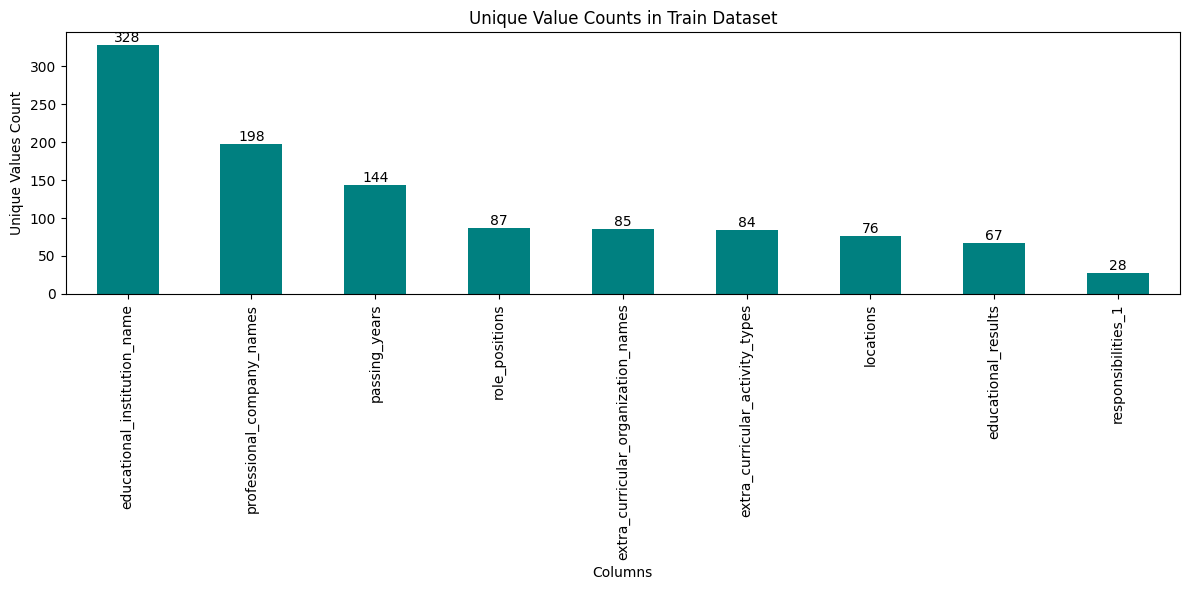

In [43]:
def plot_unique_value_counts(df, title="Unique Value Counts"):
    unique_counts = df.nunique().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    ax = unique_counts.plot(kind='bar', color='teal')
    
    # Add counts on top of each bar
    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())), 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='bottom', 
            fontsize=10
        )
    
    plt.title(title)
    plt.xlabel('Columns')
    plt.ylabel('Unique Values Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


left_columns = [
     'educational_institution_name',
     'passing_years',
     'educational_results',
     'professional_company_names',
     'locations',
     'extra_curricular_activity_types',
     'extra_curricular_organization_names',
     'role_positions',
     'responsibilities_1'
]

df = train_copy[left_columns]
# Example usage
plot_unique_value_counts(df, title="Unique Value Counts in Train Dataset")


In [44]:
train_copy.drop(columns=left_columns, inplace=True)
test_copy.drop(columns=left_columns, inplace=True)

print(train_copy.shape)
print(test_copy.shape)

(7635, 8473)
(1909, 8472)


# Preprocessing Pipeline

In [45]:
"""
Decisions:
Remove ID column of test data
Remove proficiency_levels, languages, address, expiry_dates, issue_dates, online_links, certification_skills, certification_providers
joto type r none/nan ase shbgula ke "missing" diye replace korano
Remove extra curricular org links,company_urls,result_types,age_requirement,	
new coln persure korsi from experiencere_requirement,start_dates,end_dates and so remove these then
fixing coln names 
run tf_idf on remaining sentence cat colmn 
"""

'\nDecisions:\nRemove ID column of test data\nRemove proficiency_levels, languages, address, expiry_dates, issue_dates, online_links, certification_skills, certification_providers\njoto type r none/nan ase shbgula ke "missing" diye replace korano\nRemove extra curricular org links,company_urls,result_types,age_requirement,\t\nnew coln persure korsi from experiencere_requirement,start_dates,end_dates and so remove these then\nfixing coln names \nrun tf_idf on remaining sentence cat colmn \n'

In [46]:
# def create_preprocessing_pipeline():
#     """
#     Creates a preprocessing pipeline:
#       1. Drops unnecessary columns.
#       2. Creates two combined text columns from specified text fields.
#       3. Applies TF–IDF transformation to the combined text columns.
#       4. Processes numeric columns.
#       5. Outputs a combined feature matrix.
#     """
#     # Columns to drop
#     cols_to_drop = [
#         'extra_curricular_organization_links',
#         'online_links',
#         'issue_dates',
#         'expiry_dates',
#         'responsibilities.1'
#     ]
    
#     # Numeric columns to include
#     numeric_cols = []  # Replace with actual numeric columns

#     # Combine columns for general combined text
#     combine_general_text = FunctionTransformer(lambda df: df.assign(
#         combined_text_general=(
#             df["responsibilities"].fillna("") + " " +
#             df["\ufeffjob_position_name"].fillna("") + " " +
#             df["skills_required"].fillna("") + " " +
#             df["educationaL_requirements"].fillna("")
#         )
#     ), validate=False)

#     # Combine columns for extracurricular combined text
#     combine_extracurricular_text = FunctionTransformer(lambda df: df.assign(
#         combined_text_extracurricular=(
#             df["skills"].fillna("") + " " +
#             df["major_field_of_studies"].fillna("") + " " +
#             df["related_skils_in_job"].fillna("") + " " +
#             df["positions"].fillna("") + " " +
#             df["career_objective"].fillna("") + " " +
#             df["role_positions"].fillna("") + " " +
#             df["extra_curricular_activity_types"].fillna("") + " " +
#             df["certification_skills"].fillna("")
#         )
#     ), validate=False)

#     # TF–IDF for general combined text
#     text_general_transformer = Pipeline(steps=[
#         ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000))
#     ])

#     # TF–IDF for extracurricular combined text
#     text_extracurricular_transformer = Pipeline(steps=[
#         ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000))
#     ])
    
#     # Numeric transformations (e.g., scaling)
#     numeric_transformer = Pipeline(steps=[
#         ('scaler', StandardScaler())
#     ])
    
#     # Combine text and numeric columns
#     column_transformer = ColumnTransformer(
#         transformers=[
#             ('text_general', text_general_transformer, 'combined_text_general'),  # TF–IDF for general text
#             ('text_extracurricular', text_extracurricular_transformer, 'combined_text_extracurricular'),  # TF–IDF for extracurricular text
#             ('numeric', numeric_transformer, numeric_cols)  # Scale numeric columns
#         ],
#         remainder='drop'  # Drop any columns not specified
#     )

#     # Full pipeline with column dropping
#     full_pipeline = Pipeline(steps=[
#         ('drop_columns', FunctionTransformer(lambda df: df.drop(columns=cols_to_drop, errors='ignore'))),
#         ('combine_general_text', combine_general_text),
#         ('combine_extracurricular_text', combine_extracurricular_text),
#         ('column_transform', column_transformer)
#     ])
    
#     return full_pipeline

# Training Pipeline

In [47]:
train = train_copy.copy()
test = test_copy.copy()

In [48]:
if(train['matched_score'].dtype != "float"):
    train['matched_score'] = pd.to_numeric(train['matched_score'], errors='coerce')
    
print(train.dtypes)

matched_score                   float64
duration_months                   int64
duration_years                  float64
experience_min_years            float64
experience_max_years            float64
                                 ...   
responsibilities_1_tfidf_331    float64
responsibilities_1_tfidf_332    float64
responsibilities_1_tfidf_333    float64
responsibilities_1_tfidf_334    float64
responsibilities_1_tfidf_335    float64
Length: 8473, dtype: object


### Popping the target Column

In [49]:
y_full = train.pop('matched_score')
X_train, X_valid, y_train, y_valid = train_test_split(train, y_full, train_size=0.98, test_size=0.02, random_state=42)
X_train.head(2)

print(X_train.shape)
print(test.shape)

(7482, 8472)
(1909, 8472)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36062
[LightGBM] [Info] Number of data points in the train set: 7482, number of used features: 8112
[LightGBM] [Info] Start training from score 0.660341


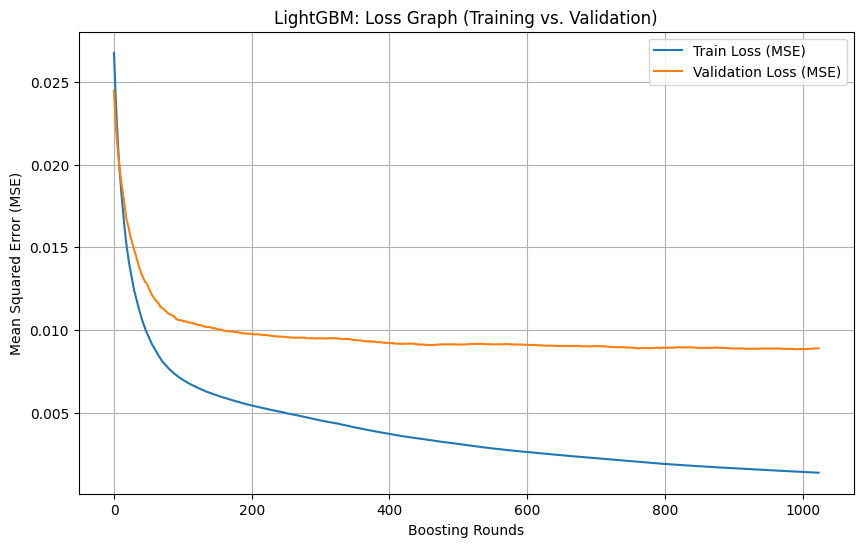

Validation MSE: 0.0088897


In [50]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import lightgbm as lgb

def score_dataset(X_train, X_valid, y_train, y_valid):
    model = LGBMRegressor(
        n_estimators=1024,
        learning_rate=0.05,
        random_state=0
    )
    
    # Create evaluation set
    eval_set = [(X_train, y_train), (X_valid, y_valid)]
    eval_names = ['train', 'valid']
    
    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_names=eval_names,
        eval_metric='l2',
        callbacks=[lgb.log_evaluation(period=0)]  # Suppress verbose output
    )
    
    eval_result = model.evals_result_
    train_mse = eval_result['train']['l2']
    valid_mse = eval_result['valid']['l2']
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_mse, label="Train Loss (MSE)")
    plt.plot(valid_mse, label="Validation Loss (MSE)")
    plt.title("LightGBM: Loss Graph (Training vs. Validation)")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    preds = model.predict(X_valid)
    mse = mean_squared_error(y_valid, preds)
    return model, mse

# Example Usage
model, mse = score_dataset(X_train, X_valid, y_train, y_valid)
print(f"Validation MSE: {mse:.7f}")


In [51]:
"""
replacing nan with missing : Validation MSE: 0.0082073 (better)
98% traindata - 0.0088897 but got the best result on public board
and then on public score we get - 0.0077001


Decision: 

# checkout the coln names and check all good
# checkout the null and drop cols . also replace the nan with "missing". we used "none" but it made bad score 
maybe bcz of cant d
# null value handle krar por valid score bad hye jae ! OMG ! it happens bcz ur model is doing random
# then find coln datatype and target is not convert into float datatype or int
# make normalization if needed for numerical cols

# plot uniqye entries of cat datas: 
range type cat data thakle e.g from 2 to 5years , then we can use max and min year limits in new columns. 
and if any row blank, fill with SimpleImputer

# try to find out relations betn cols like "degree_names" and "passing_years"
# check if categorical data or sentences present ( then nlp embedder needed )
# Date deya thakle need special processing


# Train data 98% niye kaj korle got better public Score ! so checkout if effect asee. it may look bad on validation score 
but good on public score!
# training rate 0.02/0.05 better 
# also plot graph to understand "overfit","dropout","batch", "epochs" needed


"""

'\nreplacing nan with missing : Validation MSE: 0.0082073 (better)\n98% traindata - 0.0088897 but got the best result on public board\nand then on public score we get - 0.0077001\n\n\nDecision: \n\n# checkout the coln names and check all good\n# checkout the null and drop cols . also replace the nan with "missing". we used "none" but it made bad score \nmaybe bcz of cant d\n# null value handle krar por valid score bad hye jae ! OMG ! it happens bcz ur model is doing random\n# then find coln datatype and target is not convert into float datatype or int\n# make normalization if needed for numerical cols\n\n# plot uniqye entries of cat datas: \nrange type cat data thakle e.g from 2 to 5years , then we can use max and min year limits in new columns. \nand if any row blank, fill with SimpleImputer\n\n# try to find out relations betn cols like "degree_names" and "passing_years"\n# check if categorical data or sentences present ( then nlp embedder needed )\n# Date deya thakle need special pro

# Prediction 

In [52]:
import pandas as pd

def predict_and_save_submission(model, X_test, output_filename="submission.csv"):
    print(X_test.shape)

    # Predict the matched_score for the test set
    test_preds = model.predict(X_test)
    
    # Dynamically generate the ID column starting from 1
    submission = pd.DataFrame({
        "ID": range(1, len(X_test) + 1),  # Generate row numbers starting from 1
        "matched_score": test_preds
    })
    
    # Save to CSV
    submission.to_csv(output_filename, index=False)
    print(f"Submission file saved as {output_filename}")
    
    return submission

# Example Usage
submission = predict_and_save_submission(model, test, output_filename="submission.csv")

# Preview the submission file
#print(submission.head())


(1909, 8472)
Submission file saved as submission.csv


In [53]:
print("ready to goooooooooo")

ready to goooooooooo
